# An Inferential Analysis of Factors Influencing Airbnb Prices in Athens
## STAT 301: Statistical Modelling for Data Science

### Group 33: 
- Lexie Wen: 34889204
- Marylyn Yuwono: 45608643
- Xinghao Huang: 81848509
- Zhenyu Zhong: 50922293

### Date: December 6, 2025
---

## Introduction

- ***Relevant Background:*** Airbnb is a widely used accommodation platform with listings that vary in location, quality, room type, and host features. Understanding what factors influence pricing is useful for travellers seeking fair prices and for hosts aiming to set competitive rates.

- ***Research Question:*** How are listing characteristics (e.g., room type, superhost status), location features (e.g., distance to metro station or city centre), satisfaction ratings (overall and cleanliness), and booking timing (weekday vs. weekend) associated with the full price of an Airbnb stay for two people and two nights in Athens?

- ***Primary Goal:*** The primary goal of this question is inference. We aim to quantify associations from observational data, not estimate causal effects (which is not possible with our non-experimental dataset).

- Our analysis aligns with the existing literature on Airbnb price determinants, although we restrict attention to Athens and use only tools taught in class (multiple linear regression, variable selection through VIF, diagnostics, and model comparison).


---

## Methods and Results

### a) Data

**Reproducible Code**

In [7]:
# Load Athens Airbnb datasets from GitHub URLs of our repository
athens_weekdays <- read.csv("https://raw.githubusercontent.com/XH-DP3/STAT-301-Project-Final-Report---Group-33/refs/heads/main/data/athens_weekdays.csv", header = TRUE)
athens_weekends <- read.csv("https://raw.githubusercontent.com/XH-DP3/STAT-301-Project-Final-Report---Group-33/refs/heads/main/data/athens_weekends.csv", header = TRUE)

**Citation of Open Source**

- All data-loading scripts and reproducible code used in this project are hosted in our public GitHub repository (Huang et al., 2025).

**Data Collection Information:** 
- The datasets were originally obtained from Gyódi and Nawaro (2021), Determinants of Airbnb Prices in European Cities: A Spatial Econometrics Approach (supplementary material), published on Zenodo.

- The data were **observational** since the variables were collected from Airbnb listings without any treatment assignment or random process.

- This dataset offers a detailed overview of Airbnb prices in Athens, including information on room type, cleanliness and satisfaction ratings, number of bedrooms, distance from the city centre, and other attributes that help explain price differences between weekday and weekend stays.

**Variable Summary**

| Variable | Type | Description |
|-----------|-----------|-----------|
| realSum | Quantitative data | the total prices of the listing |
| room_type | Categorical/nominal data | different room types, including *private*, *shared*, *entire home*, *apt*. |
| room_shared | Categorical/binary data| whether a room is shared |
| room_private | Categorical/binary data | whether a room is private |
| person_capacity | Quantitative data | number of people a room can accommodate |
| host_is_superhost | Categorical/binary data | whether a host is a superhost |
| multi | Categorical/binary data | whether the listing is for multiple rooms |
| biz| Categorical/binary data | whether an observation is associated with a business |
| cleanliness_rating | Quantitative data | rating of cleanliness |
| guest_satisfaction_overall | Quantitative data | overall rating from guests comparing all listings offered by the host |
| bedrooms | Quantitative data | number of bedrooms |
| dist | Quantitative data | distance from city center |
| metro_dist | Quantitative data | distance from the nearest metro station |
| attr_index | Quantitative data | attr index |
| attr_index_norm | Quantitative data | normalized attr index |
| rest_index | Quantitative data | rest index |
| rest_index_norm | Quantitative data | normalized rest index |
| lng | Quantitative data | longitude coordiates for location identification |
| lat | Quantitative data | latitude coordiates for location identification |


**Preselection of Variables**

- ***room_shared***, ***room_private***, and ***multi*** have redundant information because we can also acquire the same and even more complete information from ***room_type*** and ***bedrooms***.

- ***lng*** and ***lat*** will be dropped because they only provide raw spatial coordinates, and information regarding distance can be acquired from ***dist*** and ***metro_dist***

- ***attr_index***, ***attr_index_norm***, ***rest_index***, and ***rest_index_norm*** will also be dropped because their definitions and interpretations are unclear from the dataset documentation, and they seem like post-analysis results.

### b) Exploratory Data Analysis

In [8]:
# Load necessary libraries
install.packages("tidyverse")
install.packages("ggplot2")
install.packages("patchwork")

library(tidyverse)
library(ggplot2)
library(patchwork)


The downloaded binary packages are in
	/var/folders/z2/0v9m6dxx6bnbxcv2q29tp4br0000gn/T//RtmpTfibit/downloaded_packages

The downloaded binary packages are in
	/var/folders/z2/0v9m6dxx6bnbxcv2q29tp4br0000gn/T//RtmpTfibit/downloaded_packages

The downloaded binary packages are in
	/var/folders/z2/0v9m6dxx6bnbxcv2q29tp4br0000gn/T//RtmpTfibit/downloaded_packages


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.1     ✔ stringr   1.5.2
✔ lubridate 1.9.4     ✔ tibble    3.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ scales::col_factor() masks readr::col_factor()
✖ dplyr::combine()     masks gridExtra::combine()
✖ purrr::discard()     masks scales::discard()
✖ dplyr::filter()      masks stats::filter()
✖ stringr::fixed()     masks recipes::fixed()
✖ dplyr::lag()         masks stats::lag()
✖ dplyr::recode()      masks car::recode()
✖ purrr::some()        masks car::some()
✖ yardstick::spec()    masks readr::spec()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


**Data Wrangling**

In [9]:
# Add an indicator column 'day_type' to each dataset
athens_weekdays <- athens_weekdays %>% mutate(day_type = as.factor("Weekdays"))
athens_weekends <- athens_weekends %>% mutate(day_type = as.factor("Weekends"))

# Combine the two datasets into one
athens <- rbind(athens_weekdays, athens_weekends)

**Potential Problem(s)**

In [10]:
summary(athens$realSum)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
   42.88    98.66   127.72   151.74   171.54 18545.45 

- Note that there are extreme outliers in ***realSum***. They will make it harder to see the pattern of the majority of individual observations. Therefore, we are going to apply log transformation in the EDA visualizations in order to observe a clear pattern.

**Visualization 1**

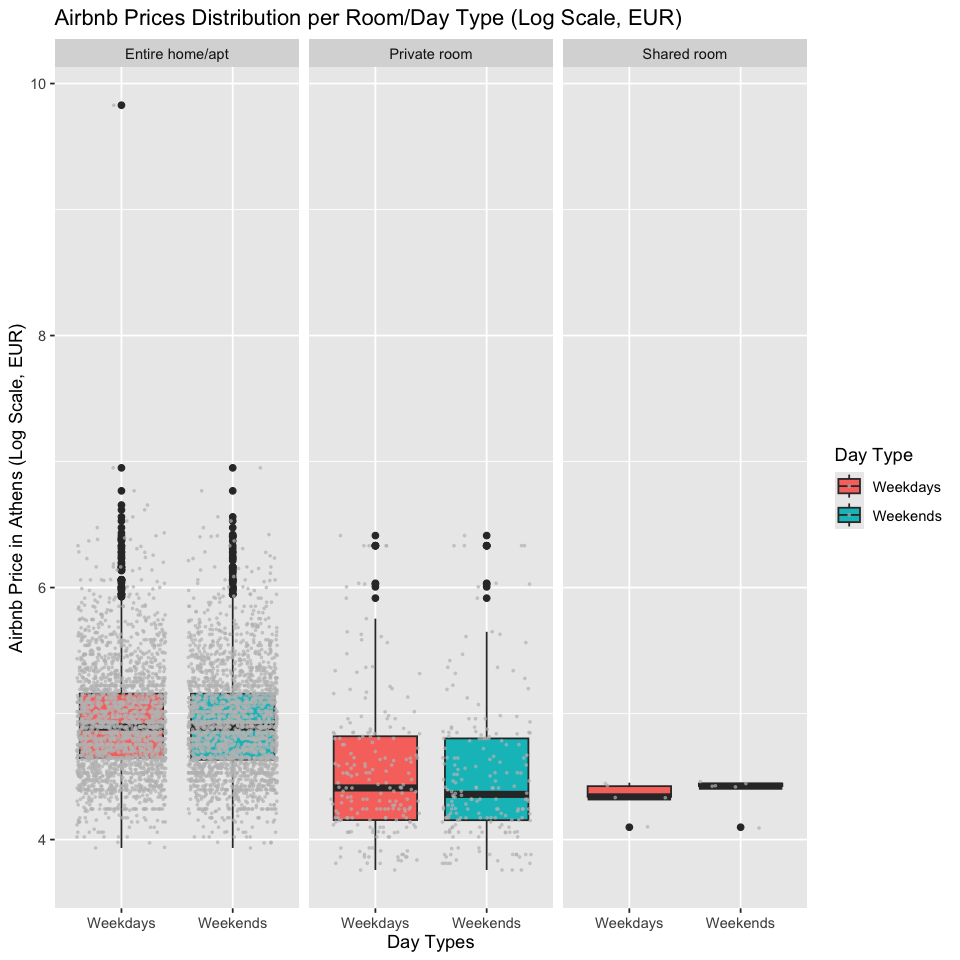

In [32]:
# boxplot with points of log-transformed realSum by day_type and faceted by room_type
box_price_by_room_original <- athens %>%
    ggplot(aes(x = day_type, y = log(realSum), fill = day_type)) +
    geom_boxplot(fatten = 4) + # adjust the width of the median bar
    geom_jitter(color="gray", size=0.4, alpha=0.6) + # adding individual observations
    facet_grid(~room_type) + # facet by room_type
    ggtitle("Airbnb Prices Distribution per Room/Day Type (Log Scale, EUR)") +
    labs(x = "Day Types", y = "Airbnb Price in Athens (Log Scale, EUR)", fill = "Day Type")

options(repr.plot.width = 8, repr.plot.height = 8)
box_price_by_room_original

**Visualization 2**

`geom_smooth()` using formula = 'y ~ x'


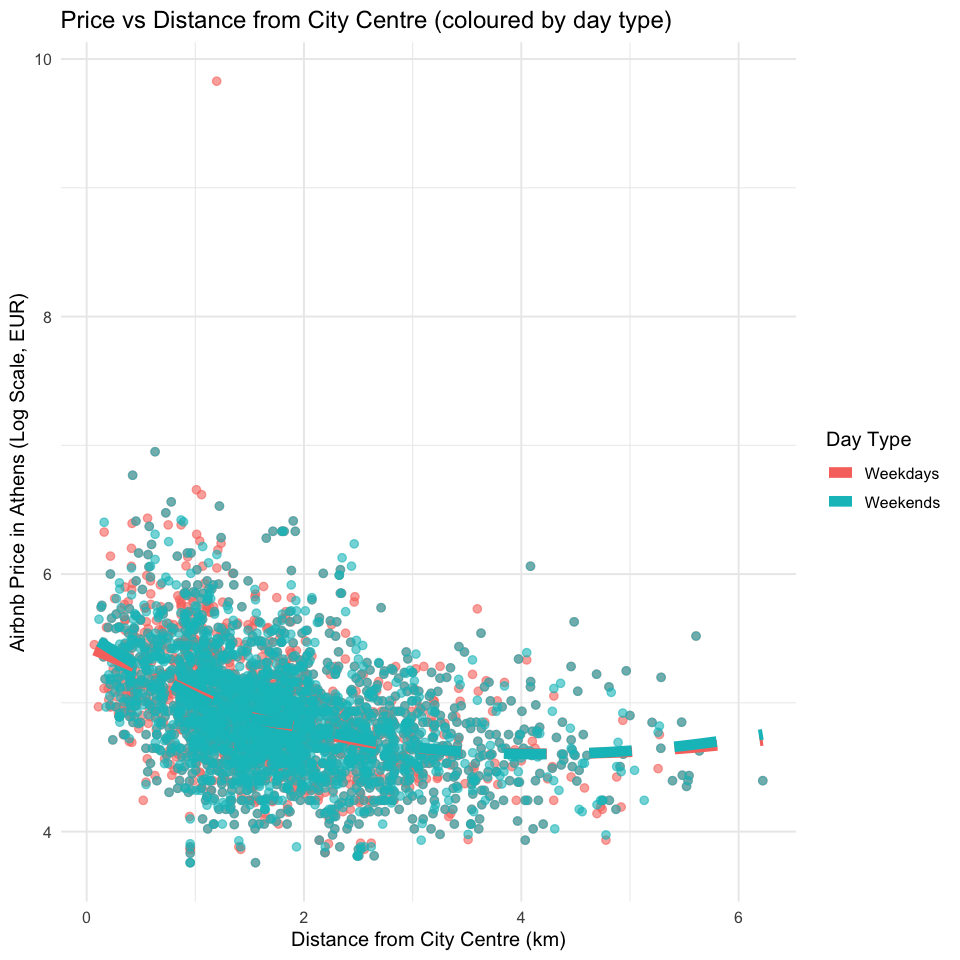

In [33]:
# scatterplot of price vs distance (using filtered realSum values)
scatter_distance_by_day <- ggplot(athens, aes(x = dist, y = log(realSum), color = day_type)) +
  geom_point(alpha = 0.6, size = 2) +      # plot individual observations
  geom_smooth(aes(group = day_type), method = "loess", se = FALSE, linetype = "dashed", linewidth = 3) +     # add smoothed trend lines
  labs(
    title = "Price vs Distance from City Centre (coloured by day type)",
    x = "Distance from City Centre (km)",
    y = "Airbnb Price in Athens (Log Scale, EUR)",
    color = "Day Type"
  ) +
  theme_minimal(base_size = 12) +
  theme(legend.position = "right")

scatter_distance_by_day

### c) Methods: Plan

- **Model Selection:** 

    - A multiple linear regression model will be suitable to address the proposed question.

- **Model selection Justifications:**
        
    - The response (Airbnb price) is continuous, so MLR is the correct modelling family. 
        
    - It allows us to select multiple covariates and model the expected Airbnb price.
        
    - And, since the response will be the Airbnb price, Logistic regression that models the log-odds or Poisson regression that models the log-mean count are not appropriate to model the price.

- **Model Assessment Plan:**

    - **Dataset Split:** 
        - We will split the dataset into two subsets: one for variable selection (~70%) and one for inference (~30%).

        - *Justification:* Model selection on the full dataset inflates Type I error rates because the same data drive both the selection and inference stages. This can avoid “double-dipping”. 

    - **Multicollinearity Check:** 
        - We will compute VIF/GVIF for all predictors and remove those with unusually high values to reduce multicollinearity.

        - *Justification:* Removing predictors with extreme VIF values stabilizes coefficient estimates and improves interpretability, 

    - **Model Comparison:** 
        - We will fit a full model (after VIF screening) and some reduced models based on EDA, and use a nested-model F-test to evaluate whether the full model provides significantly better explanatory power.
        
        - *Justification:* This process confirms that removing predictors does not harm the model. F-tests help ensure we keep only variables that meaningfully improve the fit.

    - **Diagnostic Checks:** 
        - We will use diagnostic plots to assess linearity, normality of residuals, constant variance, and influential observations.

        - *Justification:* The model is only appropriate if classical linear regression assumptions are reasonably satisfied. (1) Linear relationship between predictors and response; (2) Independence of observations; (3) Normally distributed errors; (4) Constant variance residuals

    
    - **Transformation (if needed):** 
        - Transforming variables (e.g., log) to address skewness or heteroscedasticity, Adding polynomial or interaction terms to address patterns in residual plots.

    
    - **Inference and Interpretation:** 
        - We will fit the final model on the inference dataset, and interpret the coefficients of the final model in terms of the associations between predictors and the response, and perform hypothesis tests to assess whether these relationships are statistically significant.

        - *Justification:* Refitting on the untouched inference set ensures valid inference by providing unbiased estimates and correct standard errors.


### d) Code and Results



In [13]:
# load necessary libraries for modeling
install.packages("car")
install.packages("gridExtra")
install.packages("readr")
install.packages("dplyr")
install.packages("rsample")
install.packages("leaps")
install.packages("tidymodels")
install.packages("workflows")

library(car)
library(gridExtra)
library(readr)
library(dplyr)
library(rsample)
library(leaps)
library(tidymodels)
library(workflows)


The downloaded binary packages are in
	/var/folders/z2/0v9m6dxx6bnbxcv2q29tp4br0000gn/T//RtmpTfibit/downloaded_packages

The downloaded binary packages are in
	/var/folders/z2/0v9m6dxx6bnbxcv2q29tp4br0000gn/T//RtmpTfibit/downloaded_packages

The downloaded binary packages are in
	/var/folders/z2/0v9m6dxx6bnbxcv2q29tp4br0000gn/T//RtmpTfibit/downloaded_packages

The downloaded binary packages are in
	/var/folders/z2/0v9m6dxx6bnbxcv2q29tp4br0000gn/T//RtmpTfibit/downloaded_packages

The downloaded binary packages are in
	/var/folders/z2/0v9m6dxx6bnbxcv2q29tp4br0000gn/T//RtmpTfibit/downloaded_packages

The downloaded binary packages are in
	/var/folders/z2/0v9m6dxx6bnbxcv2q29tp4br0000gn/T//RtmpTfibit/downloaded_packages

The downloaded binary packages are in
	/var/folders/z2/0v9m6dxx6bnbxcv2q29tp4br0000gn/T//RtmpTfibit/downloaded_packages

The downloaded binary packages are in
	/var/folders/z2/0v9m6dxx6bnbxcv2q29tp4br0000gn/T//RtmpTfibit/downloaded_packages


**Split the Dataset**

In [28]:
set.seed(1234)

# Split the data into training (70%) and testing (30%) sets; note that the dataset is already loaded in the previous steps
athens_split <- 
    athens  %>%
    initial_split(prop = 0.7)

# Create training and testing datasets
athens_selection <- training(athens_split)
athens_inference <- testing(athens_split)


**VIF Checking**

- To ensure interpretability in an inference-focused analysis, we construct our full model using predictors directly related to our research question: room_type, host_is_superhost, dist, metro_dist, guest_satisfaction_overall, cleanliness_rating, and day_type.

In [15]:
# The full model contains all predictors (except room_shared and room_private since they are contained in romm_type. Otherwise it will cause the aliasing problem) in the dataset
model_for_vif <- lm(realSum ~  room_type + host_is_superhost + dist + metro_dist + guest_satisfaction_overall + cleanliness_rating + day_type, data = athens_selection)

# Calculate VIF for each predictor in the full model
vif_values <- vif(model_for_vif)

vif_values


,GVIF,Df,GVIF^(1/(2*Df))
room_type,1.018422,2,1.004574
host_is_superhost,1.096993,1,1.047374
dist,1.011163,1,1.005566
metro_dist,1.012184,1,1.006074
guest_satisfaction_overall,2.238485,1,1.496157
cleanliness_rating,2.246016,1,1.498671
day_type,1.000625,1,1.000313


- The VIF values are all low and within acceptable ranges, indicating no concerning multicollinearity among the predictors. Therefore, no variables will be removed at this stage.

**Nested Model Comparison**

- It is possible that simpler models may explain the data just as well as our full model. To investigate this, we propose two nested reduced models and compare them with the full model using F-tests.

In [16]:
# This model contains all the predictors selected after VIF check
model_full <- model_for_vif

# This model removes satisfaction features
model_reduced_1 <- lm(realSum ~ room_type + host_is_superhost + dist + metro_dist + day_type, data = athens_selection)

# This is another reduced model, which contains
model_reduced_2 <- lm(realSum~  room_type + host_is_superhost + guest_satisfaction_overall + cleanliness_rating + day_type, data = athens_selection)

In [17]:
# Perform ANOVA to compare the reduced model 1 with the full model
anova_result_1 <- anova(model_reduced_1, model_full)

# Perform ANOVA to compare the reduced model 2 with the full model
anova_result_2 <- anova(model_reduced_2, model_full)

# Extract the p-value from the ANOVA results
anova_p_1 <- anova_result_1$`Pr(>F)`[2]
anova_p_2 <- anova_result_2$`Pr(>F)`[2]

anova_p_1
anova_p_2


[1] 0.2341822

[1] 1.274211e-09

- The F-test for Reduced Model 1 gives a p-value of 0.234 (>0.05), so we do not reject the null. Removing the satisfaction variables does not worsen the model, meaning this reduced model performs as well as the full model.

- Reduced Model 2 has a very small p-value (<0.05), so we reject the null. Removing the location variables significantly harms model fit, indicating they are important predictors.

- Therefore, we choose **Reduced Model 1** for inference because it performs similarly to the full model while being simpler.

**Model Diagonsis**

- We now evaluate the selected model for potential violations of regression assumptions, including linearity, normality, and constant variance.

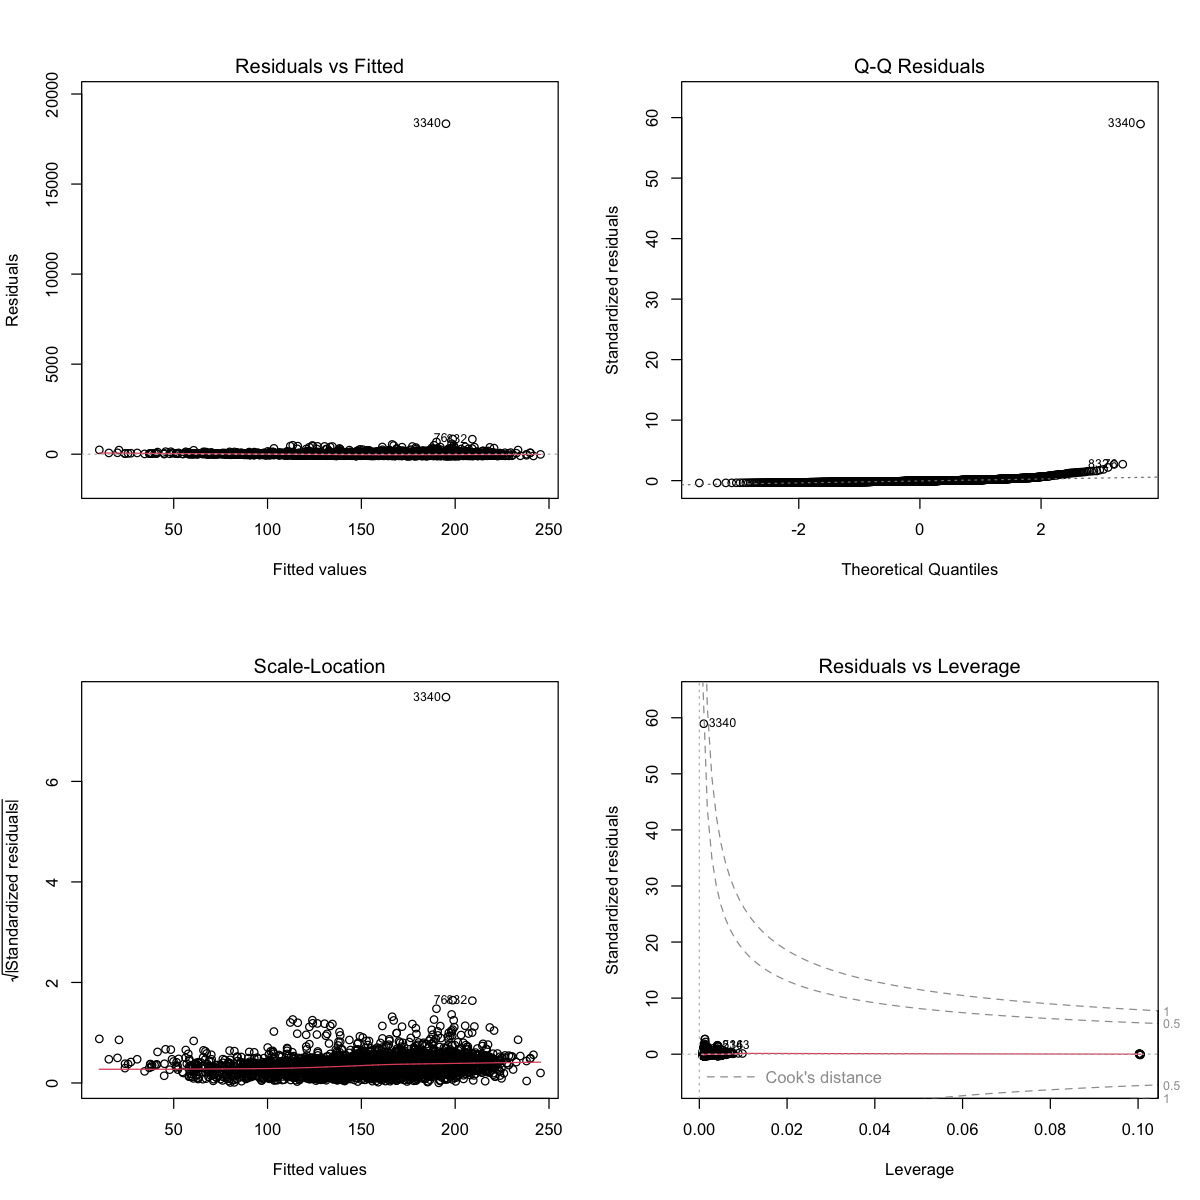

In [18]:
# Diagnostic plots for the first reduced model
options(repr.plot.width = 10, repr.plot.height = 10)
par(mfrow = c(2, 2))
plot(model_reduced_1)

- Issues:

    - **Heteroscedasticity:** Because one residual is extremely large, the Residuals vs Fitted plot is stretched and hides the pattern. The Scale–Location plot shows increasing spread with larger fitted values, indicating non-constant variance.

    - **Non-normal residuals:** The Q–Q plot shows several points far above the reference line in the right tail. This tells us the residuals are right-skewed and do not follow a normal distribution, which affects inference.

    - **Outliers:** Some observations (such as ID 3340) have very large residuals or high leverage. These points have a strong influence on the model and contribute to the issues above. Since they are likely real listings, we cannot remove them in an inference study.


- Adjustment:

    - To address the above issues, we will apply a logarithmic transformation to the response variable (realSum). Modeling log(realSum) typically stabilizes variance, reduces right-skewness, and mitigates the influence of extreme price values, leading to a model that better satisfies linear regression assumptions.

Warning message:
“not plotting observations with leverage one:
  122”


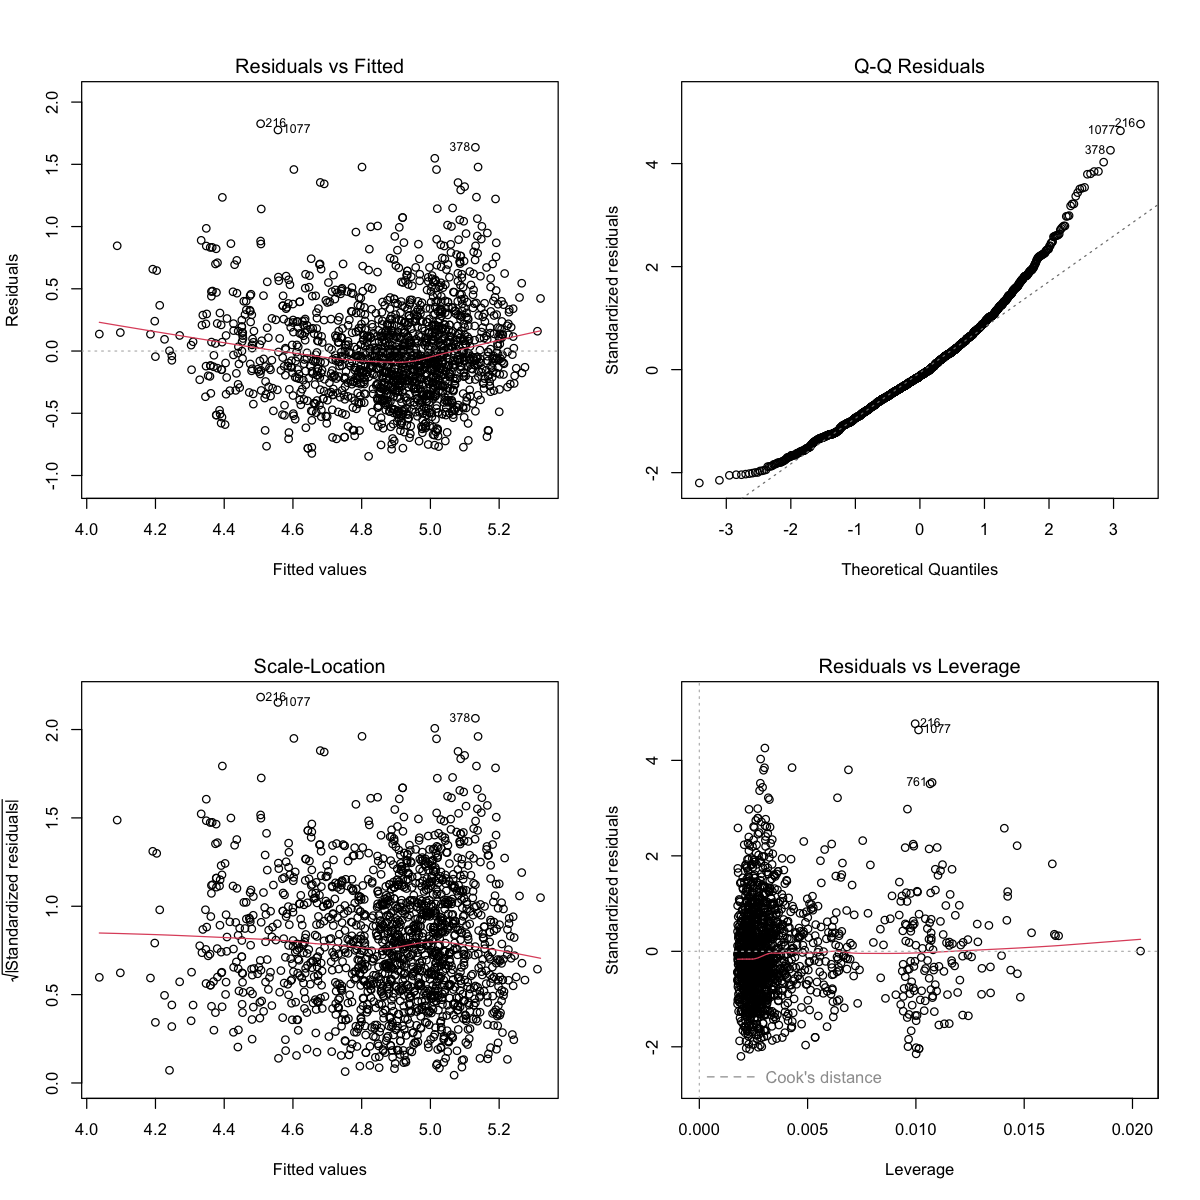

In [19]:
# Apply log transformation to the response variable to address the above issues
model_reduced_1_log <- lm(log(realSum) ~ room_type + host_is_superhost + dist + metro_dist + day_type, data = athens_inference)

# Diagnostic plots for the transformed model
par(mfrow = c(2, 2))
plot(model_reduced_1_log)

- After applying a logarithmic transformation to the response, diagnostic plots show substantial improvement in model assumptions. Residuals exhibit homoscedasticity, approximate normality, and no severe influential points. Therefore, the transformed model is considered appropriate for inference.

**Intepretations**

In [26]:
# Assign the final model
finalized_model <- lm(log(realSum) ~ room_type + host_is_superhost + dist + metro_dist + day_type, data = athens_inference)

In [27]:
# Perform tidy to get the model summary with exponentiated coefficients and confidence intervals
result <- tidy(finalized_model, exponentiate = TRUE, conf.int = TRUE) %>% mutate_if(is.numeric, round, 3)

result

# Adjusted R-squared values for the models
summary(model_full)$adj.r.squared # adjusted R-squared for the full model (the one proposed by our research question)

summary(model_reduced_2)$adj.r.squared # adjusted R-squared for the second reduced model

summary(model_reduced_1)$adj.r.squared # adjusted R-squared for the first reduced model without log transformation

summary(finalized_model)$adj.r.squared # adjusted R-squared for the first reduced model (our final model) with log transformation

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),197.628,0.028,186.074,0.000,186.917,208.954
room_typePrivate room,0.667,0.037,-10.845,0.000,0.620,0.718
room_typeShared room,0.560,0.385,-1.506,0.132,0.263,1.192
host_is_superhostTrue,1.073,0.020,3.562,0.000,1.032,1.115
dist,0.845,0.010,-17.033,0.000,0.829,0.862
metro_dist,0.811,0.034,-6.137,0.000,0.758,0.867
day_typeWeekends,1.011,0.019,0.589,0.556,0.974,1.051


[1] 0.01243509

[1] 0.001940784

[1] 0.01219289

[1] 0.2347126

**room_type**

- We estimate that, holding other variables at their reference levels, and distance variables (dist, metro_dist) at 0, the mean price of entire home/apt is estimated to be 197.628 EUR.

- Holding other variables constant, private rooms are expected to be priced 33.3% lower than entire home/apt (multiplicative effect of 0.667, 95% CI: [0.620, 0.718]). 

- At 5% significance level, there is statistical evidence that private rooms differ in mean price relative to entire homes. While there is no evidence to say that shared rooms differ in price relative the entire homes at the same significance level.

**host_is_superhost**

- We estimate that, holding other variables constant, listings hosted by a superhost are expected to be priced about 7.3% higher than those hosted by a non-superhost (multiplicative effect of 1.073, CI: [1.032, 1.115]).

- At 5% significance level, there is statistical evidence that superhost status is associated with a difference in mean price compared to non-superhosts.

**dist**

- We estimate that, holding other variables constant, each additional kilometer between the listing and city center is associated with an estimated 15.5% decrease in the mean price of listing (multiplicative effect of 0.845, 95% CI: [0.829, 0.862]).

- At 5% significance level, there is statistical evidence that distance from city center is negatively associated with the expected total price of listing.

**metro_dist**

- We estimate that, holding other variables constant, each additional kilometer between the listing and the nearest metro station is associated with an estimated 18.9% decrease in the expected total price of listing (multiplicative effect of 0.811, 95% CI: [0.758, 0.867]).

- At 5% significance level, there is statistical evidence that distance from the nearest metro station is associated with the expected total price of listing.


**daytype**

- At 5% significance level, there is no statistical evidence to say that the expected price of listing on weekends is different compared to the price on weekdays.

**Adjusted R-squared Comparison**

- Our selection steps produced a simpler model that meets key assumptions and explains the response well. After removing unnecessary predictors and applying a log transformation, the final model achieved the highest adjusted R-squared (0.2347), making it the strongest choice for our research question.

---

## Discussion

**Implications of Our Findings**

- Our results highlight several meaningful determinants of Airbnb listing prices, offering insights that extend beyond Athens and can inform decision-making for both hosts and travelers.

    - **Room type matters:** Entire homes are priced much higher, while private rooms are about one-third cheaper. Travelers looking for affordable stays can often save significantly by choosing private rooms without sacrificing location.

    - **Superhost status adds value:** Listings run by superhosts cost about 7% more, suggesting that guests are willing to pay a small premium for higher reliability and better service.

    - **Location plays a major role:** Prices drop as listings move farther from the city center or the nearest metro station. This indicates that accessibility and conveniency are the core. Travelers seeking lower prices may find better deals by looking a bit farther from the city center and the nearest metro station.

    - **No weekend price premium:** We did not find evidence that weekends are priced higher than weekdays in Athens, which means prices remain relatively stable across days.

**Evaluation of Findings Against Expectations**

- These results largely matched expectations, particularly the importance of room type and central location. 

- However, the lack of a statistically significant weekend premium was less expected. We anticipated higher weekend pricing due to tourism demand, but the non-significant p-value indicates insufficient evidence to support this.

**Limitations of the Current Model and Paths for Improvement**

- Although the multiple linear regression model provided meaningful insights, there are several ways the model itself could be improved to better satisfy regression assumptions and reduce estimation uncertainty.

- First, the response variable (price in euros) is highly right-skewed and contains extreme outliers, which may result in heteroscedasticity and violation of linearity assumptions. Applying a log-transformation to the response or using robust regression techniques could stabilize the variance and provide more reliable standard errors.

- Additionally, several potentially important predictors, such as neighbourhood-level variables, season of stay, proximity to major attractions, and property size, were not included in the model due to data limitations. Incorporating these covariates could reduce omitted variable bias and improve explanatory power. 


**Directions for Future Research**

- Given the strong effect of distance from the city centre and the clear spatial structure of Airbnb listings, a natural next step would be to incorporate spatial econometric methods such as spatial lag or spatial error models, which account for the possibility that nearby listings influence each other’s prices. These models could reduce omitted spatial dependence and provide more accurate standard errors than ordinary multiple linear regression. 

- Beyond improving the model itself, this study opens several directions for broader, future research on Airbnb pricing in Athens and similar urban markets. Extending the analysis to multiple cities would allow comparison across urban environments and help determine whether the determinants of price are city-specific or generalizable across European markets. 


---
## References

GitHub repository (reproducible code)
- Huang, X., Group 33. (2025). STAT 301 Project Final Report — Group 33 [GitHub repository]. https://github.com/XH-DP3/STAT-301-Project-Final-Report---Group-33

Original Dataset Source
- Gyódi, K., & Nawaro, Ł. (2021, March 25). Determinants of Airbnb prices in European cities: A Spatial Econometrics Approach (supplementary material). Zenodo. https://zenodo.org/records/4446043#.Y9Y9ENJBwUE 